In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vowpalwabbit import pyvw

%matplotlib inline

In [2]:
# Generate some count data that has poisson distribution 
# z ~ poisson(x + y), x \in [0,10), y \in [0,10)
x = np.random.choice(range(0,10), 100)
y = np.random.choice(range(0,10), 100)
z = np.random.poisson(x + y)

We will model this data in two ways
* log transform the labels and use linear prediction (square loss)
* model it directly using poisson loss

The first model predicts mean(log(label)) the second predicts log(mean(label)). Due to [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen's_inequality), the first approach produces systematic negative bias

In [3]:
# Train log-transform model
training_samples = []
logz = np.log(0.001 + z)
vw = pyvw.vw("-b 2 --loss_function squared -l 0.1 --holdout_off -f vw.log.model --readable_model vw.readable.log.model")
for i in range(len(logz)):
    training_samples.append("{label} | x:{x} y:{y}".format(label=logz[i], x=x[i], y=y[i]))
# Do hundred passes over the data and store the model in vw.log.model
for iteration in xrange(100):
    for i in range(len(training_samples)):
        vw.learn(training_samples[i])
vw.finish()

In [4]:
# Generate predictions from the log-transform model
vw = pyvw.vw("-i vw.log.model -t")
log_predictions = [vw.predict(sample) for sample in training_samples]
# Measure bias in the log-domain
log_bias = np.mean(log_predictions - logz)
bias = np.mean(np.exp(log_predictions) - z)



Although the model is relatively unbiased in the log-domain where we trained our model, in the original domain there is underprediction as we expected from Jensenn's inequality 

In [5]:
# Train original domain model using poisson regression
training_samples = []
vw = pyvw.vw("-b 2 --loss_function poisson -l 0.1 --holdout_off -f vw.poisson.model --readable_model vw.readable.poisson.model")
for i in range(len(z)):
    training_samples.append("{label} | x:{x} y:{y}".format(label=z[i], x=x[i], y=y[i]))
# Do hundred passes over the data and store the model in vw.log.model
for iteration in xrange(100):
    for i in range(len(training_samples)):
        vw.learn(training_samples[i])
vw.finish()

In [6]:
# Generate predictions from the poisson model
vw = pyvw.vw("-i vw.poisson.model")
poisson_predictions = [np.exp(vw.predict(sample)) for sample in training_samples]
poisson_bias = np.mean(poisson_predictions - z)


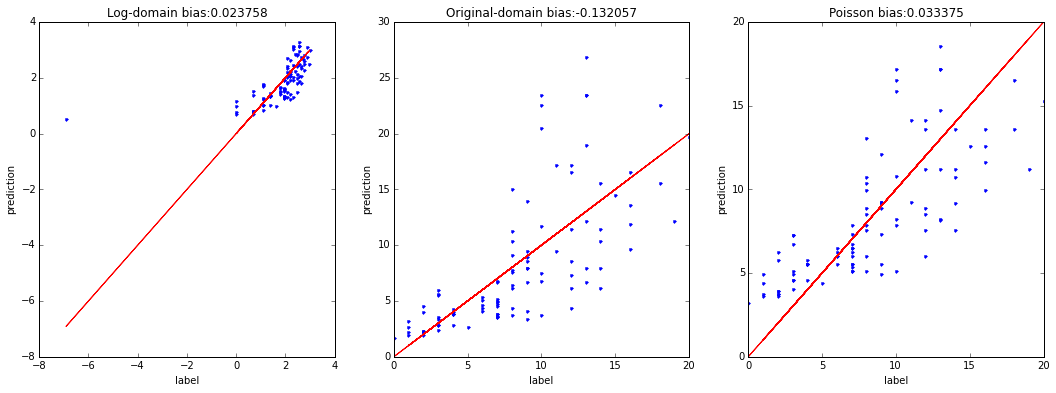

In [7]:

plt.figure(figsize=(18,6))
# Measure bias in the log-domain
plt.subplot(131)
plt.plot(logz, log_predictions, '.')
plt.plot(logz, logz, 'r')
plt.title('Log-domain bias:%f'%(log_bias))
plt.xlabel('label')
plt.ylabel('prediction')

plt.subplot(132)
plt.plot(z, np.exp(log_predictions), '.')
plt.plot(z, z, 'r')
plt.title('Original-domain bias:%f'%(bias))
plt.xlabel('label')
plt.ylabel('prediction')

plt.subplot(133)
plt.plot(z, poisson_predictions, '.')
plt.plot(z, z, 'r')
plt.title('Poisson bias:%f'%(poisson_bias))
plt.xlabel('label')
plt.ylabel('prediction')